### Shocks to Inflation

This notebook constructs all shocks to inflation used to explore conditional responses of inflation expectations

- Oil shocks: Hamilton (1996) （no need for SVAR)
- Technology shocks: Gali(1999)
- News shocks: Sims et al.(2014)

In [85]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import pandas as pd
from numpy import linalg as LA

import statsmodels.api as sm
from statsmodels.tsa.api import VAR, SVAR
from statsmodels.tsa.base.datetools import dates_from_str

### Structural VAR (Gali (1999))

A vector of variables: $\Delta x_t$, $\Delta n_t$ and $\pi_t$

$$\left[\begin{array} \\\Delta x_t\\ \Delta n_t \\ \pi_t  \end{array}\right] = \left[\begin{array} \\ C(L)_{11}, C(L)_{12}, C(L)_{13} \\ C(L)_{21}, C(L)_{22}, C(L)_{23} \\ C(L)_{31}, C(L)_{32}, C(L)_{33} \end{array}  \right]   \left[\begin{array} \\ \epsilon_t^z \\ \epsilon^m_t \\ \epsilon^\pi_t  \end{array}\right] $$

Identification restriction is 

- Orthogonality + normalization: $E(\epsilon \epsilon')= I$   
- $C(1)_{12}=0$
- $C(1)_{13}=0$
- $C(1)_{23}=0$

Then $C(L)$ is lower triangluar and just identified. This is so called long-run restrictions from Blanchard and Quah (1989). 

Rewriting it into a general form of SVAR, we have  

$$A(L) \left[\begin{array} \\\Delta x_t\\ \Delta n_t \\ \pi_t  \end{array}\right] =\left[\begin{array} \\ u_t^z \\ u^m_t \\ u^\pi_t  \end{array}\right]  =B \left[\begin{array} \\ \epsilon_t^z \\ \epsilon^m_t \\ \epsilon^\pi_t  \end{array}\right] $$

where $u_t$ is reduced form residul and $\epsilon_t$ is structural shock. 


$$\left[\begin{array} \\\Delta x_t\\ \Delta n_t \\ \pi_t  \end{array}\right] =A(L)^{-1} B \left[\begin{array} \\ \epsilon_t^z \\ \epsilon^m_t \\ \epsilon^\pi_t  \end{array}\right] = \mathbf{C}(L) \left[\begin{array} \\ \epsilon_t^z \\ \epsilon^m_t \\ \epsilon^\pi_t  \end{array}\right] $$

With $p$ lags, we have $$A(L) = I_k - A_1L - A_2L^2-\ldots - A_pL^p$$

The estimation takes following stepss. 

1. Estimate OLS to get estimates $\hat A_1, \hat A_2, \ldots, \hat A_p$ and $\hat \Sigma^u$.

2. Use the following to sovle $\hat B$, $$(I_k - \hat A_1 - \ldots - \hat A_p)^{-1} \hat B = Col((I_k - \hat A_1 - \ldots - \hat A_p)\hat \Sigma^u(I_k - \hat A'_1 - \ldots - \hat A'_p)^{-1})$$ 

The existing SVAR package in *Statsmodels* only handles cases with direct zero restrictions on $B$ matrices. Therefore I write my own codes using long-run restrictions here.  

In [86]:
## technology shock data
ts_data = pd.read_excel('../OtherData/Emp.xls',sheet_name='data')
ts_data['observation_date'] = pd.to_datetime(ts_data['observation_date'],format='%Y%m%d')

## dates 
datesQ = ts_data['observation_date'].dt.year.astype(int).astype(str) + \
         "Q" + ts_data['observation_date'].dt.quarter.astype(int).astype(str)
datesQ = dates_from_str(datesQ)


## inflation data (monthly to quarterly)
inf_dataM = pd.read_stata('../OtherData/InfM.dta')
filterQ = inf_dataM['month'].isin([3,6,9,12])
inf_dataQ = inf_dataM[filterQ]
infQ = inf_dataQ['CPIAU'].pct_change()
inf_datesQ = inf_dataQ['date'].dt.year.astype(int).astype(str) + \
             "Q" + inf_dataQ['date'].dt.quarter.astype(int).astype(str)
inf_datesQ = dates_from_str(inf_datesQ)

In [87]:
# set date index to productivity and labor series
ts_var1 = ts_data[['DLPROD1','DLHOURS']]
ts_var2 = ts_data[['DLPROD2','DLEMP']]

ts_var1.index = pd.DatetimeIndex(datesQ,freq='Q')
ts_var2.index = pd.DatetimeIndex(datesQ,freq='Q')

# set date index to inf series 
infQ.index= pd.DatetimeIndex(inf_datesQ)

In [88]:
## merge with inflation
# order of vector for var:  [productivity, labor input, inflation]
ts_var1 = pd.concat([ts_var1,infQ], join='inner', axis=1)
ts_var2 = pd.concat([ts_var2,infQ], join='inner', axis=1)

ts_var1=ts_var1.dropna()
ts_var2=ts_var2.dropna()

In [89]:
# period filter 
start_t='1940-01-01'
end_t = '2019-03-30'

# Write the codes that estimate reduced-form VAR 
model1 = VAR(ts_var1.loc[start_t:end_t])  # var model with no restriction
model2 =VAR(ts_var2.loc[start_t:end_t])   # var model2 with no restriction


#svmodel1=SVAR(ts_var1.loc[start_t:end_t],svar_type='B',\
 #             B=np.array([['E',0,0],['E','E',0],['E','E','E']]))  # svar model with restriction
#svmodel2=SVAR(ts_var2.loc[start_t:end_t],svar_type='B',\
              # B=np.array([['E',0],['E','E']]))  # svar model with restriction

In [90]:
rs1=model1.fit(4,trend='nc')
rs2=model2.fit(4,trend='nc')
#srs1=svmodel1.fit(4)
#srs2=svmodel2.fit(4,solver='nm')

In [91]:
rs1.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 28, May, 2019
Time:                     10:02:44
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -33.0086
Nobs:                     279.000    HQIC:                  -33.2892
Log likelihood:           3518.41    FPE:                2.89162e-15
AIC:                     -33.4771    Det(Omega_mle):     2.54844e-15
--------------------------------------------------------------------
Results for equation DLPROD1
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
L1.DLPROD1         0.064575         0.060571            1.066           0.286
L1.DLHOURS        -0.090391         0.062992           -1.435           0.151
L1.CPIAU          -0.030113         0.029673           -1.015         

In [92]:
## define function of Blanchard and Quah long run restriction

def BQLR(rs):
    """
    inputs
    ------
    rs: result object of reduced VAR estimated using statsmodels.tsa.VAR
    
    outputs
    -------
    dictionary:
      sigma_u: ndarrray
               variance-convariance of reduced VAR residuals 
      B_est:   ndarray
               estimated B matrices using long-run restrictions
      eps_est: ndarray
               estimated structural shocks
      A_L:     adarray
               I_k - A_1 - \ldots -A_p
      C_L:     adarray 
               A_L.inv * B
    """

    k = rs1.neqs    # number of equations 
    nlags =rs1.coefs.shape[0] # number of lags 
    sigma_u = rs1.sigma_u 
    #print('Var-covariance matrix of reduced-form VAR is \n'+str((sigma_u)))
    ## Estimate B matrices 
    I_k = np.ones(k)
    AR_coefs = [rs1.coefs[i,:,:] for i in range(nlags)]
    A_L = I_k
    A_L_prime = I_k
    for i in range(len(AR_coefs)):
        #print(A_L)
        A_L = A_L - AR_coefs[i]
        #print(A_L_prime)
        A_L_prime = A_L_prime - AR_coefs[i].T
        
        B_svar_est = np.dot(A_L,LA.cholesky(
            np.dot(
                np.dot(LA.inv(A_L),
                       sigma_u),
                LA.inv(A_L_prime))
        )
                           )
        #print('Estimated B matrice is \n'+str(B_svar_est))
        ## check if the restrictions hold
        
        C_L=np.dot(LA.inv(A_L),B_svar_est)
        if np.allclose(C_L, np.tril(C_L)):
            print('C_L is indeed lower triangular, consistent with long-run restriction')
        else:
            print('Something is wrong: C_L is not lower triangular, inconsistent with long-run restriction')

        
        ## structural shocks 
        u = np.array(rs1.resid)
        epsilon_est = np.dot(LA.inv(B_svar_est),(np.array(rs1.resid).T))
        return {'sigma_u':sigma_u,'B_est':B_svar_est,'eps_est':epsilon_est,'A_L':A_L,'C_L':C_L}

In [93]:
### Invoke BQLR 

BQLR_rst = BQLR(rs1)
A_L,C_L,sigma_u,B_svar_est,epsilon_est \
     =BQLR_rst['A_L'],BQLR_rst['C_L'],BQLR_rst['sigma_u'],BQLR_rst['B_est'],BQLR_rst['eps_est']

C_L is indeed lower triangular, consistent with long-run restriction


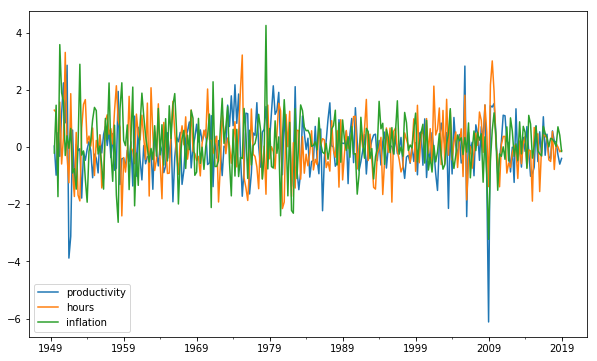

In [94]:
## Look into the structural shocks epsilon

str_shocks_est=pd.DataFrame(epsilon_est.T)
str_shocks_est.index=ts_var1.index[nlags+1:]
str_shocks_est.columns=['productivity','hours','inflation']
str_shocks_est.plot(figsize=(10,6))

In [96]:
#ts_plot1=rs1.plot()

Reduced VAR ir Plot


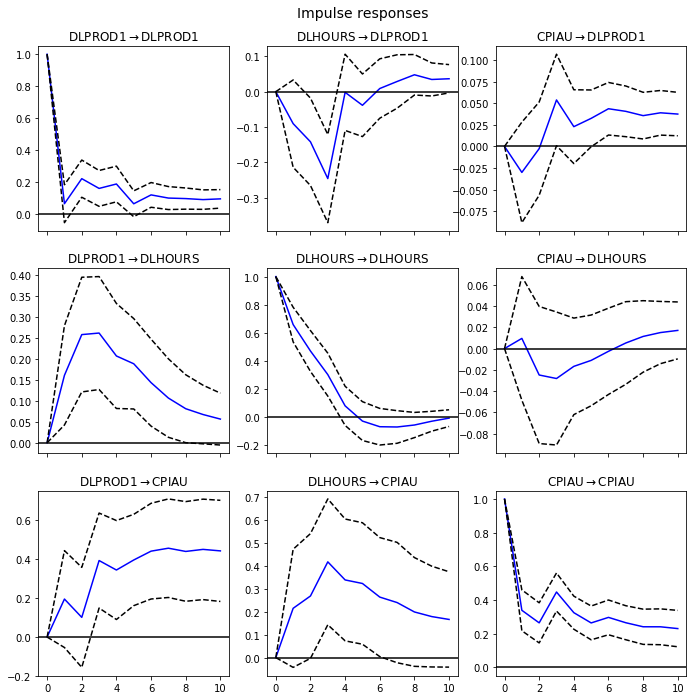

In [109]:
print('Reduced VAR ir Plot')
irf1 = rs1.irf(10)
ir_plot1=irf1.plot()
#irf2 = rs2.irf(10)
#irf2.plot()
#irf3 = srs1.irf(10)
#irf3.plot(plot_stderr=False)